# Module 10 - Regression Algorithms - Linear Regression with Transformed Target

In the last notebook, I hinted at the possibility that the relationship between mpg and the other variables is actually non-linear, despite the linear model fitting pretty well in the middle.

To correct for this, we can take the logarithm of mpg and test the relationship again!

Let's get right into this.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Part A: Loading in Dataset

We're going to load the dataset in the same way as the last notebook, now summarized!

In [2]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df = df.replace(np.nan, df.horsepower.mean())

df = df.drop("model", axis=1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,accel,year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Now, we can do our train-test split again!

In [3]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107)

Let's now plot the marginal relationships again, this time using the log of the dataset:

Notice how it's now looking much more like the normal distribution with the bell shape!

Also, in the pair plots, a lot of the curvature in the top row is gone! So we're taking a step in the right direction.

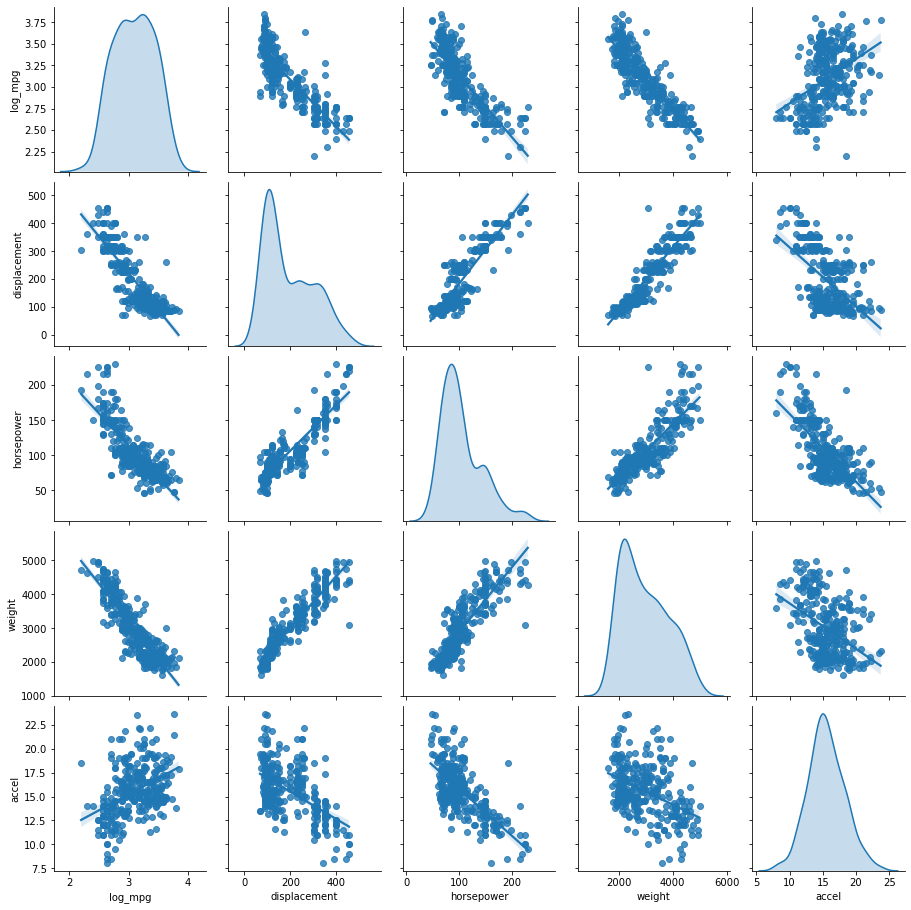

In [5]:
train_dataset = X_train.copy()
train_dataset.insert(0, "log_mpg", np.log(y_train))

sns.pairplot(train_dataset[['log_mpg','displacement','horsepower','weight','accel']], kind='reg', diag_kind='kde')

Nice! The log of mpg looks much more normal than before!!

This should lead to a better fitting model down the line.

A lot of the other curved relationships in the previous notebook are now gone, too.

## Part B: Data Preprocessing & Pipeline

The majority of the following steps are going to be exactly the same from the previous notebook!

One hot encoding is going to be slightly different, as I want to work towards building a robust model. In the previous notebook, I mentioned that encountering any new categorical variables in the test/validation sets is going to trigger errors, and prevent analysis. To work around this, we're manually dropping off the last instance (K-1) categories, and then telling SKLearn to encode any new categories as all zeroes. This means that any new categories encounterd will be encoded the exact same way as the one we dropped off (all zeros).

A huge caveat of this is we're going to lose predictive power if we encounter a ton of new categorical features in the cars we want to predict. So tread carefully. However, our only categories are cylinders (3,4,5,6,8), origin (Americas, Europe, Asia), and years (1970-1982). So we won't want to stray away from this. The good thing however, is that through the manual definition of these categories, our pipeline will not break during cross validation if a testing set has a 3 cylinder vehicle and the training set had none.

Another thing we could do is to encode all the categories, and then let the errors be all zero. However, this would introduce colinearity into the model. Which is something we'll work around in Notebook 3!

We'll start by manually defining our categories:

In [6]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

categories = [np.sort(pd.unique(X_train[str(col)]))[:-1] for col in categorical_columns]
categories

[array([3, 4, 5, 6], dtype=int64),
 array([1, 2], dtype=int64),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], dtype=int64)]

And now we can slightly tweak our preprocessor to ignore new categorical features by setting `handle_unknown='ignore'` and passing in our custom categories.

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', categories=categories), categorical_columns), remainder="passthrough")

Now, we just need to define our model with a transformed target!

This allows us to switch back and forth easier down the line, without hard coding it. It also reduces mistakes.

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,
        inverse_func=np.exp
    )
)

We still train our model exactly the same way:

In [9]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array([3, 4, 5, 6], dtype=int64),
                                                                            array([1, 2], dtype=int64),
                                                                            array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], dtype=int64)],
                                                                handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearReg

And we make predictions exactly the same way too.

And our predictions are back in normal (not log) numbers! This was completely handled for us.

In [10]:
y_pred_in = model.predict(X_train)

## Part C: Evaluating Machine Learning Model

Let's now look at our same metrics from earlier with our log (transformed target) model for mpg:

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y_train, y_pred_in)
mean_squared_error(y_train, y_pred_in)
mean_absolute_error(y_train, y_pred_in)

0.8943871778039706

6.537846136242421

1.8318057986238672

The $r^2$ value is up to 0.894 in sample! It was 0.875 in the last notebook.

Let's plot our predictions versus the truths again:

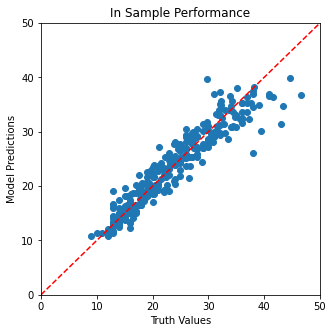

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, y_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

We're now losing a lot less to the curve on the upper end! So the .02 increase in $r^2$ isn't all, we gained a larger range with accurate predictions.

Let's plot the residuals again:

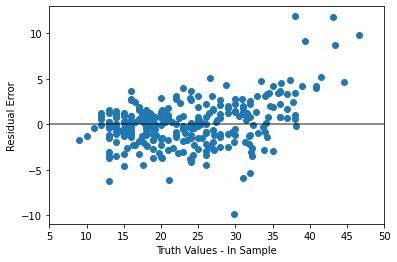

In [13]:
plt.scatter(y_train, y_train-y_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

We're capturing much more now! It's looking good.

Let's analyze our coefficients again, first by pulling out our feature names:

In [14]:
feature_names = (model.named_steps['columntransformer']
                 .named_transformers_['onehotencoder']
                 .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([feature_names, numerical_columns])
feature_names

array(['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'origin_1', 'origin_2', 'year_70', 'year_71', 'year_72', 'year_73',
       'year_74', 'year_75', 'year_76', 'year_77', 'year_78', 'year_79',
       'year_80', 'year_81', 'displacement', 'horsepower', 'weight',
       'accel'], dtype=object)

And we can pull the coefficients out of our model and easily plot once they're in a DataFrame:

`model.named_steps['transformedtargetregressor'].regressor_.coef_` pulls the coefficients out of the model.

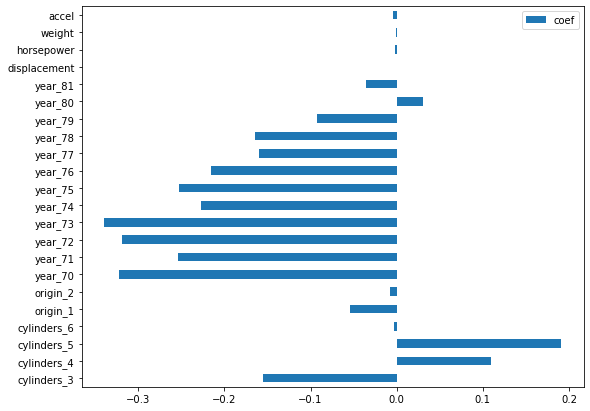

In [15]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['coef'], index=feature_names
)

coefs.plot(kind='barh', figsize=(9,7))

Remember, these are not scaled yet!

So, we cannot gauge importance based upon this graph.

Let's multiply the coefficientss by the standard deviation of the variable in the training set again to scale.

First, transform the training sample using the preprocessor:

In [16]:
X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)

X_train_preprocessed.head()

cylinders_3    0.081785
cylinders_4    0.500740
cylinders_5    0.057928
cylinders_6    0.408995
origin_1       0.483380
dtype: float64

And now we can scale the existing coefficients:

In [17]:
coefs['coefScaled'] = coefs.coef * X_train_preprocessed.std(axis=0)
coefs.head()

,coef,coefScaled
cylinders_3,-0.154740,-0.012655
cylinders_4,0.109077,0.054619
cylinders_5,0.190699,0.011047
cylinders_6,-0.003488,-0.001427
origin_1,-0.054151,-0.026176


And let's plot our scaled coeffs!

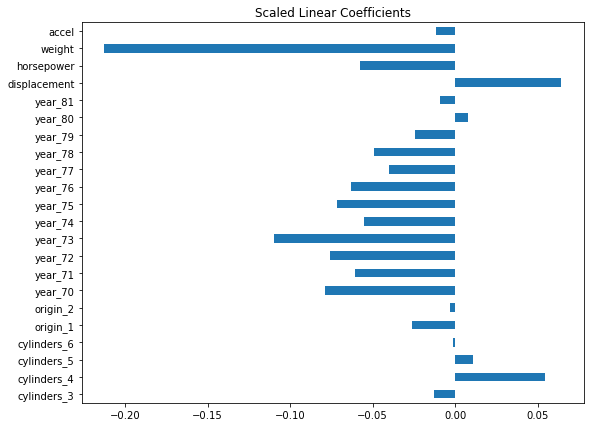

In [29]:
coefs.coefScaled.plot(kind="barh", figsize=(9,7))
plt.title("Scaled Linear Coefficients")
plt.show();

We're also going to do another cross validation, which allows us to check how stable the model is based upon our training sample.

What we're looking for is "low" variability in the coefficients!

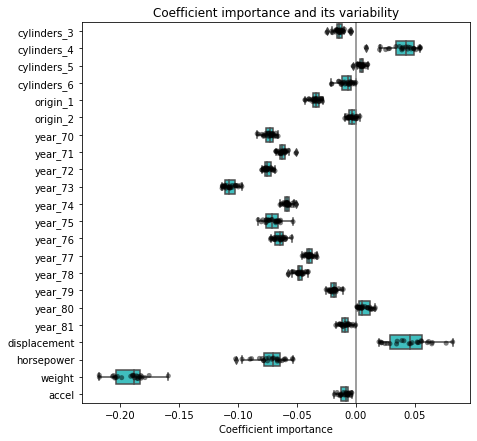

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

cv_coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ * X_train_preprocessed.std(axis=0) for est in cv_model['estimator']],
    columns=feature_names)

plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

This is a good looking graph! There's a bit of variance with displacement, however, it's not so large that it's cause for concern. The majority of the boxplot in cyan (IQR) is still pretty tight together.

Let's do our final validation, which is to analyze the test sample that we reserved:

In [19]:
y_pred_out = model.predict(X_test)

Let's plot the graph we're used to seeing for comparing truths to predictions:

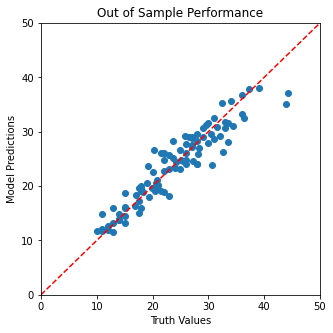

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_test, y_pred_out)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("Out of Sample Performance")
plt.show();

And now let's plot the residuals for out of sample:

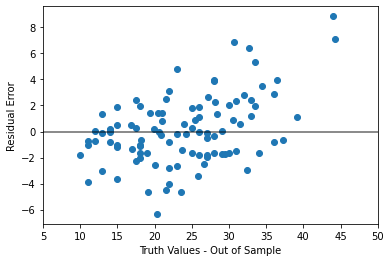

In [30]:
plt.scatter(y_test, y_test-y_pred_out)
plt.xlabel("Truth Values - Out of Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

I'd say the transformed target with logarithmic values is definitely caputuring the nonlinearity!

Let's analyze some metrics:

In [21]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, y_pred_in), mean_squared_error(y_train, y_pred_in), mean_absolute_error(y_train, y_pred_in))
metrics['out'] = (r2_score(y_test, y_pred_out), mean_squared_error(y_test, y_pred_out), mean_absolute_error(y_test, y_pred_out))

metrics

,in,out
r2,0.894387,0.880062
mse,6.537846,6.946282
mae,1.831806,1.990460


We're doing really well with our model! There's not a lot of drop off in out of sample performance!

If you're still following along, you've made it so far! It's a lot to digest at once, so don't feel bad looking back a few times.

Let's look at and compare the cross validation coefficient variation from NB1 and this Notebook:

With just linear regression:

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/linear-regression-cv.png?raw=True width="400"/>
</div>

Now, with our transformed target:

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/transformed-target-cv-variation.png?raw=True width="400"/>
</div>

What are the biggest changes that we should note by introducing the logarithmic target:

- The year coefficients become more important
- Displacement and horsepower have more explanatory power, less towards the center

Why?

Taking the log of mpg reduced some non-linearity!

## Before Next Notebook

We need to have a discussion about how we're encoding dummy variables and handling errors.

We're suppressing errors on the off chance we have a sample without all categories, which happens about once every 25 cv folds.

To fix this, we defined the categories as fixed at the top, and dropped off the last category to prevent colinearity. With how it's setup, we then encode any missing values at that dropped off category, which is an okay sacrifice in this dataset because the error was so rare during cv folds, and I do not think it impacted the model too much.

To fix this, we can stop the dropped off category and include it, and live with the colinearity in the model (which is fine for usability, as long as future data has the same colinearity). However, linear regression with colinearity means we cannot compare the coefficients to gauge relative importance.

We can also introduce a ridge regression, an algorithm designed to specifically handle colinearity, which is what we're covering next!